In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from src.encoders_decoders import *
from src.losses import *
from torch.utils.data import DataLoader
import pickle
import itertools
import random

In [4]:
#Architecture parameters and distributions of stimuli
N = 10
K = 10
p_x = torch.distributions.uniform.Uniform(-5,5)

#Training parameters
N_EPOCHS = 1000
N_SAMPLES = 10000
lr = 1e-2
BATCH_SIZE = 100

#Generate samples
x_samples = p_x.sample((N_SAMPLES,))[:,None]
x_sorted,indices = x_samples.sort(dim=0)
x_min,x_max = x_sorted[0,:].item(),x_sorted[-1,:].item()
x_data = torch.utils.data.DataLoader(x_samples,batch_size=BATCH_SIZE)
x_fine = torch.linspace(x_min,x_max,1000)[:,None]

Text(0, 0.5, 'Encoding')

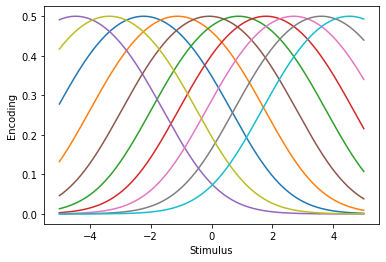

In [7]:
enc = BernoulliEncoder(N,x_min-1,x_max+1,x_sorted)
enc.log_sigmas = torch.nn.Parameter(torch.log(torch.ones(N)*(x_max-x_min)/(0.5*N))[None,:])
q = rate_ising(N)
q.J.register_hook(lambda grad: grad.fill_diagonal_(0))
dec = MLPDecoder(N,100)
#enc.As = torch.nn.Parameter(torch.ones(N)[None,:])
#Plot initial state of encoder
plt.plot(x_fine,torch.sigmoid(enc(x_fine)).detach())
plt.xlabel("Stimulus")
plt.ylabel("Encoding")

In [8]:

#dec = GaussianDecoder()
#params = itertools.chain(enc.parameters(),q.parameters())
params =  list(enc.parameters()) +  list(dec.parameters())  + list(q.parameters())
#params = q.parameters()
lr = 1e-3
opt = torch.optim.Adam(params,lr)
lVec = []
for e in range(N_EPOCHS):
    for x_ in x_data:
        rate = q(enc,x_fine)
        distortion = distortion_gaussian(x_,enc,dec)
        #print(enc.log_sigmas.grad)
        loss =  distortion + rate
        opt.zero_grad()
        loss.backward()
        opt.step()
        lVec.append(loss.item())


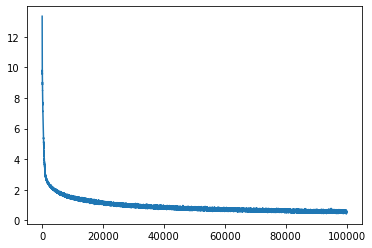

In [9]:
plt.plot(lVec)

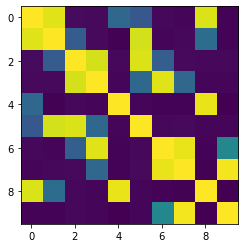

In [10]:
plt.imshow(q.J.detach())

Text(0, 0.5, 'Encoding')

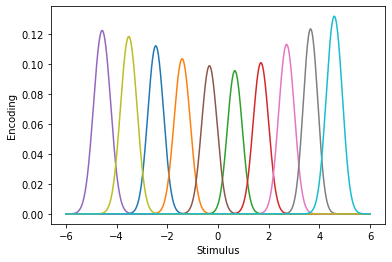

In [11]:
x_exp = torch.linspace(x_min-1,x_max+1,1000)[:,None]
plt.plot(x_exp,torch.sigmoid(enc(x_exp)).detach())
plt.xlabel("Stimulus")
plt.ylabel("Encoding")

In [12]:
r= enc.sample(x_fine,15)
mu_dec,log_sigma = dec(r)
x_ext = dec.sample(r,10)

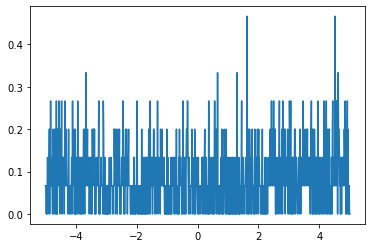

In [13]:
plt.plot(x_fine,r.sum(dim=2).mean(dim=1))

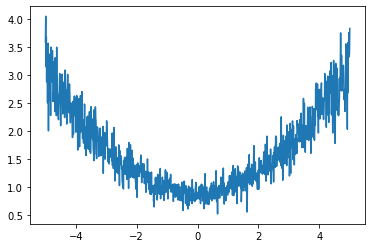

In [14]:
mseVec = ((x_ext - x_fine[None,:])**2).mean(dim=(0,2))
plt.plot(x_fine,mseVec.detach()/10)

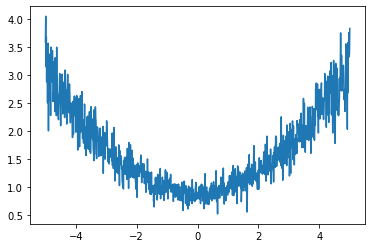

In [15]:
mseVec = ((x_ext - x_fine[None,:])**2).mean(dim=(0,2))
plt.plot(x_fine,mseVec.detach()/10)

In [18]:
def decoder_meanvar(encoder,decoder,x_fine,lat_samp = 10):
        #
        r = encoder.sample(x_fine,lat_samp)
        mu_dec,log_sigma_dec = decoder(r)
        fig,axs = plt.subplots(ncols=1,nrows=2,figsize=(10,10))
        axs[0].plot(x_fine,mu_dec.mean(dim=1).detach())
        axs[0].set_xlabel('x')
        axs[0].set_ylabel('μ')
        axs[1].plot(x_fine,torch.exp(log_sigma_dec).mean(dim=1).detach())
        axs[1].set_xlabel('x')
        axs[1].set_ylabel('σ')

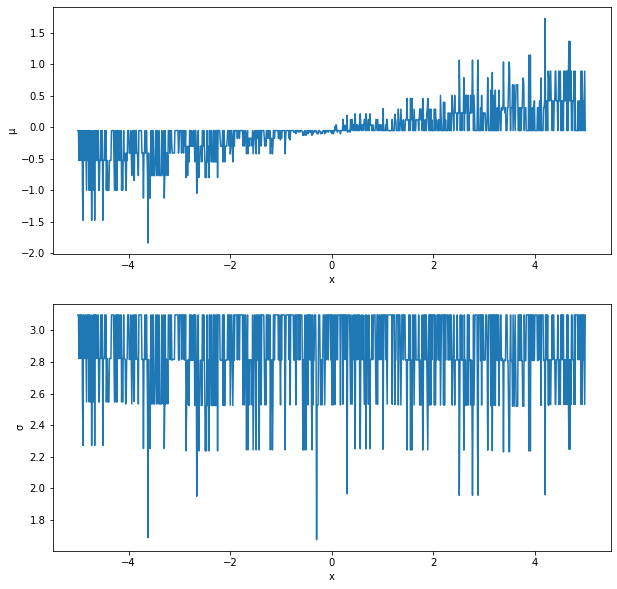

In [19]:
decoder_meanvar(enc,dec,x_fine)

In [251]:
r = enc.sample(x_fine,10)
rnp = r.reshape((-1,10)).transpose(0,1).numpy()
rd = {'5':rnp}
save_dict(rd,'myspikes.npy')

In [252]:
rd2 = load_dict('myspikes.npy')

In [196]:
torch.save(
    {'loss':lVec,'encoder': enc.state_dict()}
,'porcoddio.pt')

In [198]:
m = torch.load('porcoddio.pt')

In [202]:
m['encoder'].l

OrderedDict([('cs',
              tensor([[ 0.0675,  4.4335,  3.2888, -4.5655, -2.8193, -3.7244, -0.9309, -1.8886,
                        1.0905,  2.1560]])),
             ('log_sigmas',
              tensor([[0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931,
                       0.6931]])),
             ('As', tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]))])

In [204]:
opt.state_dict()

{'state': {0: {'step': 10000,
   'exp_avg': tensor([[-1.2704e-06, -3.8630e-07, -8.3803e-07,  5.6873e-07,  3.6082e-07,
             5.4268e-07, -7.8992e-07, -1.3724e-07, -1.6697e-06, -1.3294e-06]]),
   'exp_avg_sq': tensor([[5.4104e-10, 8.8562e-09, 4.7555e-10, 5.0995e-08, 4.8232e-10, 2.5584e-09,
            6.2380e-10, 7.8151e-10, 2.9774e-10, 5.4061e-10]])},
  1: {'step': 10000,
   'exp_avg': tensor([[ 0.0000e+00, -3.5223e-07, -7.4716e-07,  1.3139e-08, -2.1561e-07,
            -5.6126e-08, -7.4511e-07, -4.4477e-07, -1.1106e-06, -9.5683e-07],
           [-3.5223e-07,  0.0000e+00, -3.3697e-07,  8.4121e-09, -4.9582e-09,
             5.6394e-09, -1.9755e-07, -6.8633e-08, -5.2676e-07, -4.0538e-07],
           [-7.4716e-07, -3.3697e-07,  0.0000e+00,  3.8983e-09, -5.8324e-08,
            -1.1591e-08, -4.3133e-07, -1.9877e-07, -7.9939e-07, -6.8520e-07],
           [ 1.3139e-08,  8.4121e-09,  2.9669e-09,  0.0000e+00,  2.9138e-07,
             3.1446e-07,  9.6351e-08,  2.2512e-07, -5.0746e-08, -2